In [1]:
# import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# Define a list of altcoin symbols you want to track
altcoins = ["ETH-USD", "ADA-USD", "XRP-USD", "LTC-USD"]  # Example altcoins: Ethereum, Cardano, Ripple, Litecoin

In [3]:
# Create a dictionary to store historical data for each altcoin
altcoin_data = {}

In [4]:
# Fetch historical data for each altcoin
for altcoin_symbol in altcoins:
    altcoin_ticker = yf.Ticker(altcoin_symbol)
    altcoin_data[altcoin_symbol] = altcoin_ticker.history(period="1y")  # Adjust the period as needed

In [5]:
# Calculate daily returns for each altcoin
for altcoin_symbol, data in altcoin_data.items():
    data['Daily Returns'] = data['Close'].pct_change()

In [6]:
# Calculate daily volatility (standard deviation of daily returns) for each altcoin
volatility_data = {}
for altcoin_symbol, data in altcoin_data.items():
    volatility_data[altcoin_symbol] = data['Daily Returns'].std()

In [7]:
# Calculate the correlation between altcoins
correlation_matrix = pd.concat([data['Daily Returns'] for data in altcoin_data.values()], axis=1).corr()

In [8]:
# Calculate rolling statistics (e.g., moving average and standard deviation) for altcoin prices
window = 30  # Adjust the window size as needed
rolling_stats = {}
for altcoin_symbol, data in altcoin_data.items():
    data[f'{window}-Day MA'] = data['Close'].rolling(window=window).mean()
    data[f'{window}-Day Std'] = data['Close'].rolling(window=window).std()
    rolling_stats[altcoin_symbol] = data[[f'{window}-Day MA', f'{window}-Day Std']]


In [9]:
# Test for stationarity using the Augmented Dickey-Fuller test
adf_test_results = {}
for altcoin_symbol, data in altcoin_data.items():
    result = adfuller(data['Close'], autolag='AIC')
    adf_test_results[altcoin_symbol] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

In [10]:
# Calculate Bollinger Bands for each altcoin
bollinger_bands_data = {}
for altcoin_symbol, data in altcoin_data.items():
    data['Upper Band'] = data[f'{window}-Day MA'] + (2 * data[f'{window}-Day Std'])
    data['Lower Band'] = data[f'{window}-Day MA'] - (2 * data[f'{window}-Day Std'])
    bollinger_bands_data[altcoin_symbol] = data[['Close', 'Upper Band', 'Lower Band']]

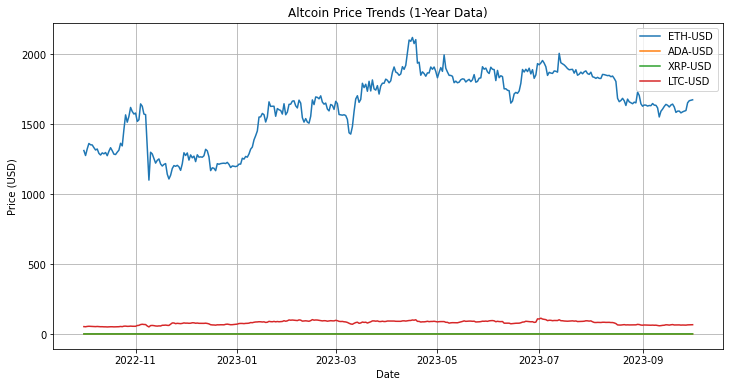

In [11]:
# Visualize altcoin price trends
plt.figure(figsize=(12, 6))
plt.title("Altcoin Price Trends (1-Year Data)")
for altcoin_symbol, data in altcoin_data.items():
    plt.plot(data['Close'], label=altcoin_symbol)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

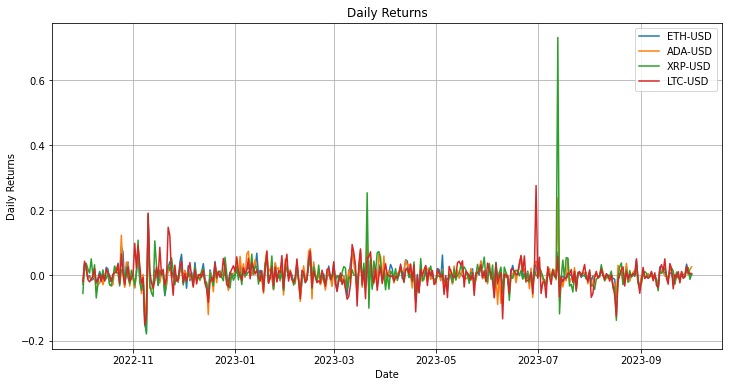

In [12]:
# Visualize daily returns
plt.figure(figsize=(12, 6))
plt.title("Daily Returns")
for altcoin_symbol, data in altcoin_data.items():
    plt.plot(data.index, data['Daily Returns'], label=altcoin_symbol)
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.legend()
plt.grid()
plt.show()

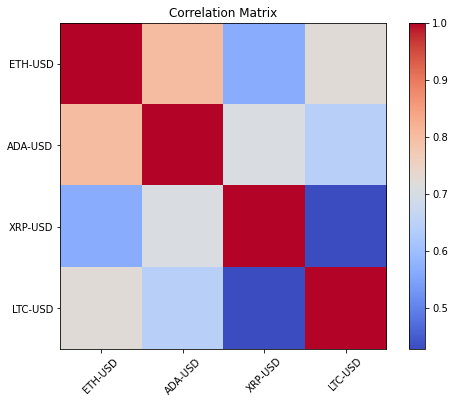

In [13]:
# Visualize altcoin correlation matrix
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix")
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(altcoins)), altcoins, rotation=45)
plt.yticks(range(len(altcoins)), altcoins)
plt.show()

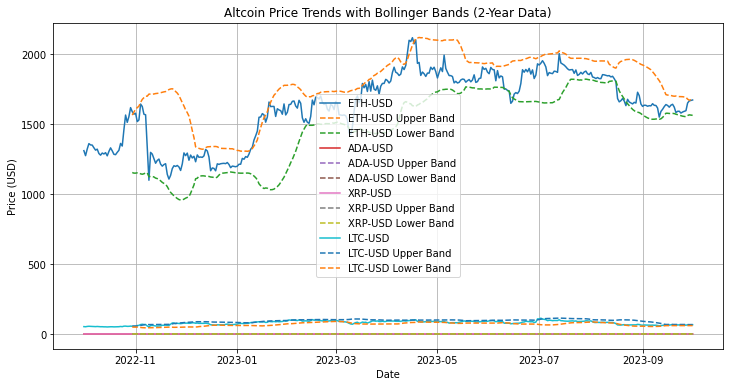

In [14]:
# Plot altcoin price trends with Bollinger Bands
plt.figure(figsize=(12, 6))
plt.title("Altcoin Price Trends with Bollinger Bands (2-Year Data)")
for altcoin_symbol, data in altcoin_data.items():
    plt.plot(data.index, data['Close'], label=altcoin_symbol)
    plt.plot(data.index, data['Upper Band'], linestyle='--', label=f'{altcoin_symbol} Upper Band')
    plt.plot(data.index, data['Lower Band'], linestyle='--', label=f'{altcoin_symbol} Lower Band')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [15]:
# Machine Learning: Linear Regression for Price Prediction (Example using Ethereum)
ethereum_data = altcoin_data["ETH-USD"].dropna()
X = np.arange(len(ethereum_data)).reshape(-1, 1)
y = ethereum_data['Close']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

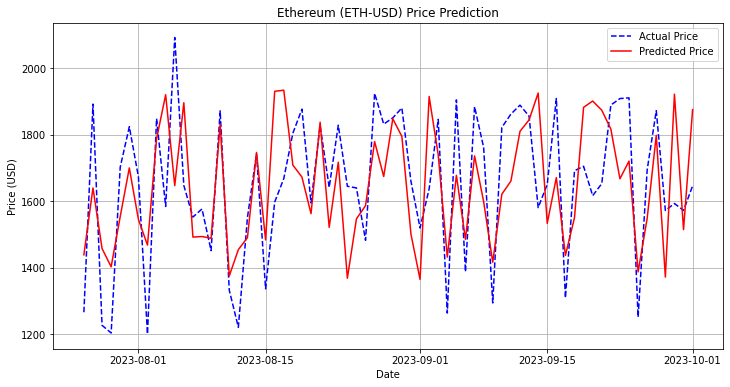

Mean Squared Error (MSE): 33907.35


In [17]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict prices
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.title("Ethereum (ETH-USD) Price Prediction")
plt.plot(ethereum_data.index[-len(X_test):], y_test, label="Actual Price", color='blue', linestyle='--')
plt.plot(ethereum_data.index[-len(X_test):], y_pred, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

print(f"Mean Squared Error (MSE): {mse:.2f}")

In [18]:
# Monte Carlo Simulation for Price Forecasting (Example using Cardano)
cardano_data = altcoin_data["ADA-USD"].dropna()
last_price = cardano_data['Close'].iloc[-1]
volatility = cardano_data['Daily Returns'].std()

In [19]:
# Number of simulations
num_simulations = 100
num_days = 365  # Number of days to forecast

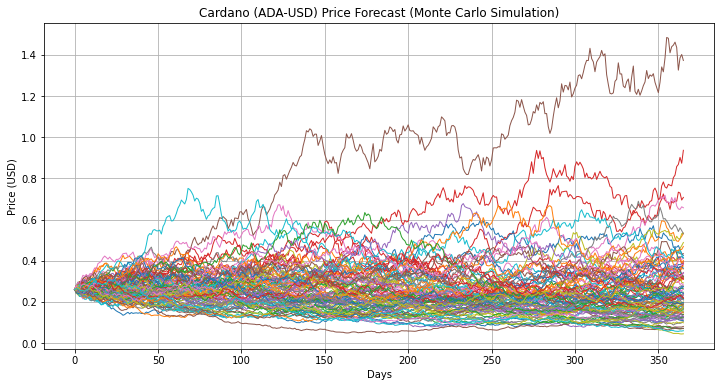

In [20]:
# Monte Carlo simulation
simulation_df = pd.DataFrame()
for i in range(num_simulations):
    daily_returns = np.random.normal(0, volatility, num_days) + 1
    price_series = [last_price]
    for j in range(num_days):
        price_series.append(price_series[-1] * daily_returns[j])
    simulation_df[f'Simulation {i+1}'] = price_series

# Visualize Monte Carlo simulations
plt.figure(figsize=(12, 6))
plt.title("Cardano (ADA-USD) Price Forecast (Monte Carlo Simulation)")
for i in range(num_simulations):
    plt.plot(simulation_df.index, simulation_df[f'Simulation {i+1}'], lw=1)
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

In [21]:
# Print daily volatility for each altcoin
print("Daily Volatility:")
for altcoin_symbol, volatility in volatility_data.items():
    print(f"{altcoin_symbol}: {volatility:.4f}")

Daily Volatility:
ETH-USD: 0.0291
ADA-USD: 0.0345
XRP-USD: 0.0519
LTC-USD: 0.0393


In [22]:
# Print ADF test results for stationarity
print("\nAugmented Dickey-Fuller Test for Stationarity:")
for altcoin_symbol, results in adf_test_results.items():
    print(f"{altcoin_symbol}:")
    print(f"ADF Statistic: {results['ADF Statistic']:.4f}")
    print(f"P-value: {results['p-value']:.4f}")
    print("Critical Values:")
    for key, value in results['Critical Values'].items():
        print(f"  {key}: {value:.4f}")
    if results['p-value'] <= 0.05:
        print("Stationary (Reject null hypothesis)\n")
    else:
        print("Non-Stationary (Fail to reject null hypothesis)\n")


Augmented Dickey-Fuller Test for Stationarity:
ETH-USD:
ADF Statistic: -1.9787
P-value: 0.2960
Critical Values:
  1%: -3.4484
  5%: -2.8695
  10%: -2.5710
Non-Stationary (Fail to reject null hypothesis)

ADA-USD:
ADF Statistic: -1.9914
P-value: 0.2904
Critical Values:
  1%: -3.4484
  5%: -2.8695
  10%: -2.5710
Non-Stationary (Fail to reject null hypothesis)

XRP-USD:
ADF Statistic: -2.0193
P-value: 0.2782
Critical Values:
  1%: -3.4484
  5%: -2.8695
  10%: -2.5710
Non-Stationary (Fail to reject null hypothesis)

LTC-USD:
ADF Statistic: -2.3868
P-value: 0.1455
Critical Values:
  1%: -3.4484
  5%: -2.8695
  10%: -2.5710
Non-Stationary (Fail to reject null hypothesis)

